In [1]:
import xarray
import pandas

In [2]:
import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils.ecIndex as ec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%run helpers/impactPlots.ipynb

# Load the sst dataset

In [3]:
paths = !find /scratch/w35/as2285/ersst/*.nc

In [5]:
paths

['/scratch/w35/as2285/ersst/ersst.v5.195701.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195702.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195703.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195704.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195705.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195706.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195707.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195708.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195709.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195710.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195711.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195712.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195801.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195802.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195803.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195804.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195805.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195806.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195807.nc',
 '/scratch/w35/as2285/ersst/ersst.v5.195808.nc',
 '/scratch/w35/as228

In [8]:
xrLs=list()
for iPath in paths:
    xrLs.append(
        to_365day_monthly(
            xarray.open_dataset(iPath, use_cftime=True).isel(lev=0,drop=True)
        )
    )
sstXr=xarray.concat(xrLs,'time')

In [9]:
sstXr.ssta

<xarray.DataArray 'ssta' (time: 775, lat: 89, lon: 180)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-5.83887100e-04, -2.39634514e-03, -5.81288338e-03, ...,
         -4.76837158e-07, -4.76837158e-07, -8.39233398e-05],
        [-4.76837158e-07, -4.76837158e-07, -4.76837158e-07, ...,
         -4.76837158e-07, -4.76837158e-07, -4.76837158e-07],
        [-4.76837158e-07, -4.76837158e-07, -4.76837158e-07, ...,
         -4.76837158e-07, -4.76837158e-07, -4.76837158e-07]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
         -3.41725349e-03, -1.00040436e-03, -5.42163849e-04],
        [-4.76837158e-07, -4.76837158e-07, -4.76837158e-07, ...,
         -4.76837158e-07, -4.76837158e-07, -4.76837158e-07],
        [-4.76837158e-07, -4.76837158e-07, -4.76837158e-07, ...,
         -4.76837158e-07, -4.76837158e-07, -4.76837158e-07]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-2.25002766e-02, -2.69587040e-02, -3.18126678e-02, ...,
         -5.14378548e-02, -2.53543854e-02, -1.93753242e-02],
        [-6.87956810e-04, -8.33749771e-04, -9.37938690e-04, ...,
         -8.33749771e-04, -8.75473022e-04, -7.50541687e-04],
        [-6.29425049e-05, -1.04665756e-04, -1.25646591e-04, ...,
         -2.14576721e-05, -4.22000885e-05, -4.22000885e-05]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1957-01-16 00:00:00 ... 2021-07-16 00:00:00
Attributes:
    long_name:  Extended reconstructed SST anomalies
    units:      degree_C
    valid_min:  -12.0
    valid_max:  12.0

In [10]:
sstClimat=sst.calculateClimatology(sstXr.sst)

In [11]:
sstIndex=sst.calculateIndex(sstXr.sst, sstClimat)

In [44]:
indexXr=tp.averageForTimePeriod(sstIndex)

In [45]:
# and EC index too
sstAnoms=ec.sstAnoms(sstXr.sst, sstXr.sst)

#create the solver
solver=ec.eofSolver(sstAnoms)

#caluculate pcs and eofs
pcXr, pFit, eofsXr = ec.pcs(solver)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [46]:
pcXr=pcXr/pcXr.std()

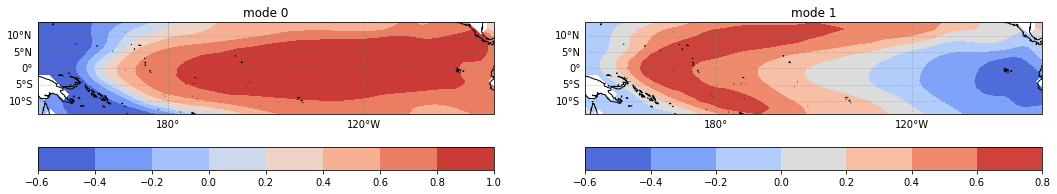

In [47]:
multiplyBy=[-1,1]

#Calc e and c
ecXr=xarray.Dataset()
ecXr['eIndex']=(multiplyBy[0]*pcXr.pc1-multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)
ecXr['cIndex']=(multiplyBy[0]*pcXr.pc1+multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)

#Average over warmseason and store
allWarmSeasXr=tp.averageForTimePeriod(ecXr)

#first plots of pc1 and pc2
fig=plt.figure(figsize=(18,12))
for mode in [0,1]:
    ax=fig.add_subplot(1,2,mode+1,
                   projection=ccrs.Miller(central_longitude=210))
    ec.ensoPlotter(
        multiplyBy[mode]*eofsXr.sel(mode=mode), ax)
    plt.title("mode " + str(mode))
plt.show()

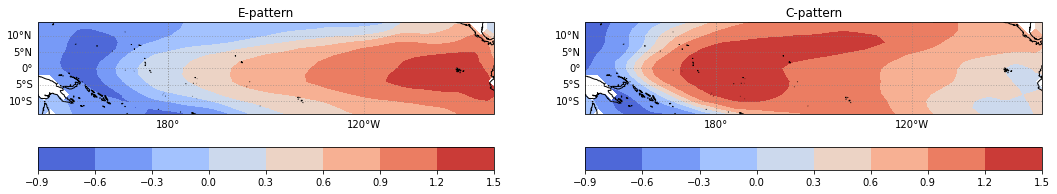

In [48]:
#then plots of e pattern and c pattern
fig=plt.figure(figsize=(18,12))
ax=fig.add_subplot(1,2,1,
               projection=ccrs.Miller(central_longitude=210))
ec.ensoPlotter(
    multiplyBy[0]*eofsXr.sel(mode=0)-multiplyBy[1]*eofsXr.sel(mode=1),
    ax)
plt.title("E-pattern")

ax=fig.add_subplot(1,2,2,
               projection=ccrs.Miller(central_longitude=210))
ec.ensoPlotter(multiplyBy[0]*eofsXr.sel(mode=0)+multiplyBy[1]*eofsXr.sel(mode=1), ax)
plt.title("C-pattern")
plt.show()

In [49]:
indexXr=xarray.merge([indexXr,allWarmSeasXr])

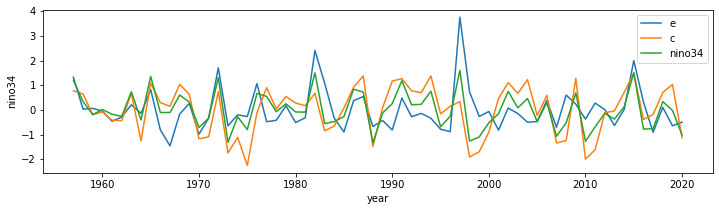

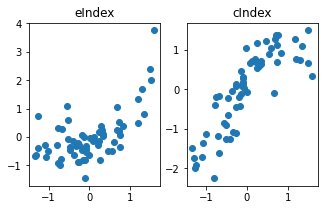

In [50]:
#plot vs time
fig = plt.figure(figsize=(12,3))
indexXr.eIndex.plot()
indexXr.cIndex.plot()
indexXr.nino34.plot()

#plt.xlim([1950,2050])
plt.legend(['e','c','nino34'])
plt.show()

#scatter plots
fig = plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.scatter(indexXr.nino34, indexXr.eIndex)
plt.title('eIndex')

plt.subplot(1,3,2)
plt.scatter(indexXr.nino34, indexXr.cIndex)
plt.title('cIndex')

plt.show()

# Marshall SAM

In [51]:
marshallPd=pandas.read_csv(
    'ref/marshallSam/newsam.1957.2007.txt',
    sep=' ', 
    skipinitialspace=True
)

In [52]:
marshallPd

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
1957,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2017,-1.12,-1.09,-1.56,1.65,1.82,1.98,0.16,0.31,0.42,-0.64,3.18,1.44
2018,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78
2020,0.57,-0.36,2.05,-1.72,1.03,1.18,-0.97,-2.20,-0.25,1.79,1.14,2.28


In [53]:
marshallXr=marshallPd.to_xarray().to_array('month').rename({'index':'year'})

In [54]:
indexXr['samMarshall']=(
     marshallXr.sel(
        year=range(1957,2021),
        month=['SEP','OCT','NOV','DEC']
    ).sum('month')  #This is the sep to dec sum for each year
    + marshallXr.sel(
        year=range(1958,2022),
        month=['JAN','FEB']
    ).sum('month').values   #This is the jan feb sum for the next year
)/6

In [55]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
Data variables:
    dmi                     (year) float64 -0.2578 -0.656 ... 1.441 0.01628
    nino34                  (year) float64 1.198 0.3367 ... -0.02116 -1.019
    nino4                   (year) float64 0.4491 0.2838 ... 0.4623 -0.6939
    eastIONoDetrend         (year) float64 -0.2096 0.2706 ... -0.5503 0.4041
    eastIO                  (year) float64 -0.1259 0.4451 ... -1.003 0.1331
    backgroundSstNoDetrend  (year) float64 -0.01563 -0.1544 ... 0.5034 0.1919
    nino4NoDetrend          (year) float64 0.4334 0.1294 ... 0.9657 -0.502
    nino34NoDetrend         (year) float64 1.183 0.1822 ... 0.4823 -0.8275
    eIndex                  (year) float64 1.321 0.03133 ... -0.6455 -0.4974
    cIndex                  (year) float64 0.7737 0.6456 ... 1.031 -1.135
    samMarshall             (year) float64 -2.208 0.71 1.108 ... -1.192 1.517

# Now, set some criteria to determine events

Per normal, 1 sigma for enso/iod. 0.5 sigma for SAM.

However, we don't have a good baseline period. Lets choose 1900-1930 (somewhat arbitrary?)

In [56]:
stdXr=indexXr.std()

In [57]:
criteriaXr=stdXr[['dmi','nino34', 'eastIO', 'eIndex', 'cIndex']]
criteriaXr['samMarshall']=stdXr.samMarshall/2

In [58]:
criteriaXr

<xarray.Dataset>
Dimensions:      ()
Data variables:
    dmi          float64 0.4737
    nino34       float64 0.7333
    eastIO       float64 0.388
    eIndex       float64 0.8552
    cIndex       float64 0.9766
    samMarshall  float64 0.5089

In [59]:
firePosXr, fireNegXr = compound.applyCriteria(indexXr, criteriaXr)

firePos: 
['dmi', 'eIndex', 'nino34', 'cIndex']
fireNeg: 
['eastIO', 'samMarshall']


In [60]:
firePosXr

<xarray.Dataset>
Dimensions:      (year: 64)
Coordinates:
  * year         (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
Data variables:
    dmi          (year) float64 0.0 0.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 1.0 1.0 0.0
    eIndex       (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    nino34       (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cIndex       (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 0.0
    eastIO       (year) float64 0.0 0.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 0.0 1.0 0.0
    samMarshall  (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 1.0 0.0

In [61]:
eventsXr=xarray.concat(
    [
        firePosXr,
        fireNegXr
    ],
    'fire')

eventsXr['fire']=['pos','neg']

In [62]:
eventsXr['ecCombined']=eventsXr[['eIndex','cIndex']].to_array().any('variable')*1.0

In [63]:
eventsXr

<xarray.Dataset>
Dimensions:      (fire: 2, year: 64)
Coordinates:
  * year         (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
  * fire         (fire) <U3 'pos' 'neg'
Data variables:
    dmi          (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0
    eIndex       (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 0.0
    nino34       (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 1.0
    cIndex       (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0
    eastIO       (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0
    samMarshall  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 1.0
    ecCombined   (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 1.0

In [64]:
eventsXr.to_netcdf('results/obsEvents.nc')

In [65]:
eventsXr

<xarray.Dataset>
Dimensions:      (fire: 2, year: 64)
Coordinates:
  * year         (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
  * fire         (fire) <U3 'pos' 'neg'
Data variables:
    dmi          (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0
    eIndex       (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 0.0
    nino34       (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 1.0
    cIndex       (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0
    eastIO       (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0
    samMarshall  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 0.0 1.0
    ecCombined   (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 1.0

In [66]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.where(
        eventsXr[iEvent].sel(fire='pos')==True, 
        drop=True
    ).year.values
    
    print(str(iEvent) + ' : ' + str(years))

dmi : [1961 1963 1967 1972 1994 1997 2006 2012 2015 2018 2019]
eIndex : [1957 1972 1976 1982 1983 1997 2015]
nino34 : [1957 1965 1972 1982 1986 1991 1994 1997 2002 2015]
cIndex : [1965 1968 1987 1990 1991 1994 2002 2004 2009 2015 2019]
eastIO : [1961 1963 1972 1994 1997 2006 2019]
samMarshall : [1957 1964 1966 1968 1970 1971 1974 1976 1979 1982 1984 1988 1991 2000
 2002 2005 2016 2019]
ecCombined : [1957 1965 1968 1972 1976 1982 1983 1987 1990 1991 1994 1997 2002 2004
 2009 2015 2019]


Cai et al. 2015, (starting 1979, using ORA-s4 SST, DJF averages) identifies El Nino as:
- CP: 1990, 2002, 2004, 2009
- EP: 1982, 1997
They seem to match ok

Abram et al 2020 (observational):
- IOD: 1982, 1991, 1994, 1997, 2007, 2008, 2012, 2015, 2019 (bad)


# If we plot some impact maps now, do they look plausible?

In [3]:
eventsXr=xarray.load_dataset('results/obsEvents.nc')

In [4]:
prTWarmSeasonXr = xarray.load_dataset('results/observPrTmaxAnoms.nc')

In [5]:
prTWarmSeasonXr

<xarray.Dataset>
Dimensions:   (lat: 691, lon: 886, year: 120)
Coordinates:
  * lat       (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon       (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * year      (year) int64 1900 1901 1902 1903 1904 ... 2015 2016 2017 2018 2019
Data variables:
    precAnom  (year, lat, lon) float64 0.0004444 0.000446 ... -0.06793 -0.06802
    tsAnom    (year, lat, lon) float32 nan nan nan ... 0.04326 0.04448 0.04579

In [6]:
eventsLs = ['eIndex', 'cIndex', 'ecCombined', 'nino34','dmi','samMarshall']

# Anoms for indiv indices - Fire Pos

In [7]:
%run helpers/impactPlots.ipynb

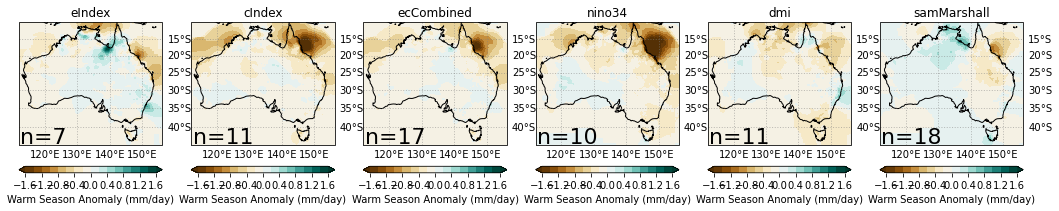

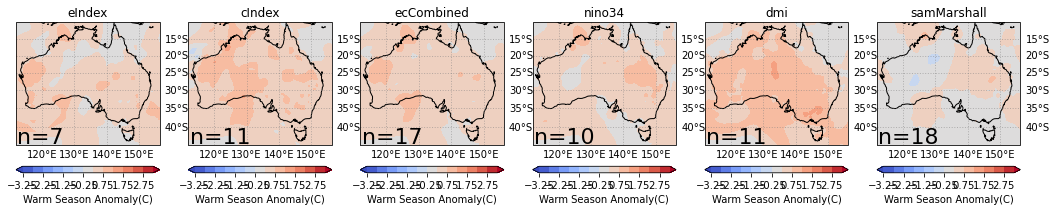

In [8]:
indexPlotter(prTWarmSeasonXr.precAnom, eventsXr.sel(fire='pos'), eventsLs)
plt.show()

indexPlotter(prTWarmSeasonXr.tsAnom, eventsXr.sel(fire='pos'), eventsLs)

In [9]:
eOnlyXr=xarray.merge([
    eventsXr.eIndex,
    eventsXr.cIndex==0
]).to_array().all('variable').to_dataset(name='eOnly')

In [10]:
eOnlyXr

<xarray.Dataset>
Dimensions:  (fire: 2, year: 64)
Coordinates:
  * year     (year) int64 1957 1958 1959 1960 1961 ... 2016 2017 2018 2019 2020
  * fire     (fire) object 'pos' 'neg'
Data variables:
    eOnly    (fire, year) bool True False False False ... True False False False

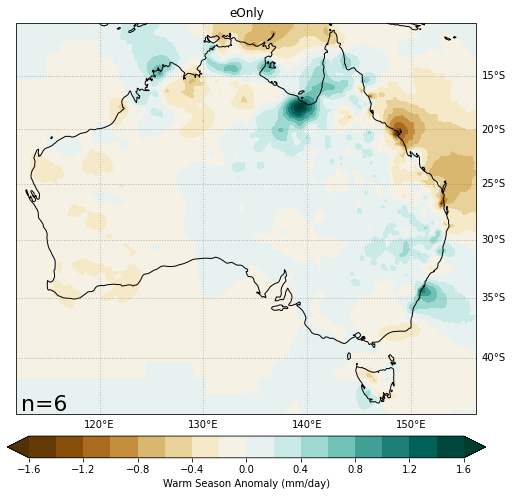

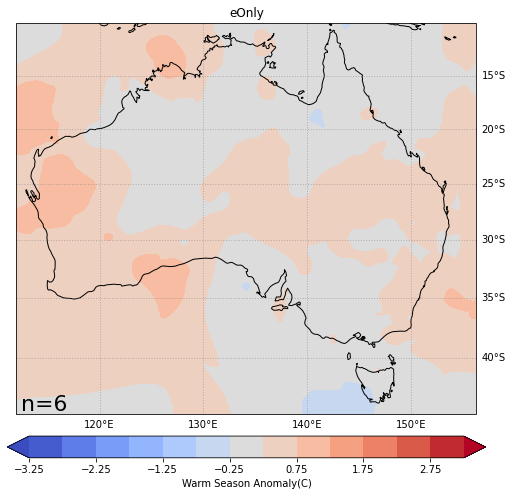

In [11]:
indexPlotter(prTWarmSeasonXr.precAnom, eOnlyXr.sel(fire='pos'), ['eOnly'])
plt.show()

indexPlotter(prTWarmSeasonXr.tsAnom, eOnlyXr.sel(fire='pos'), ['eOnly'])

# Anoms for indiv indices - Fire Neg

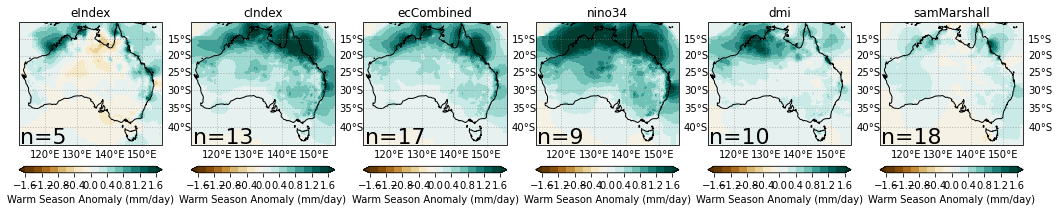

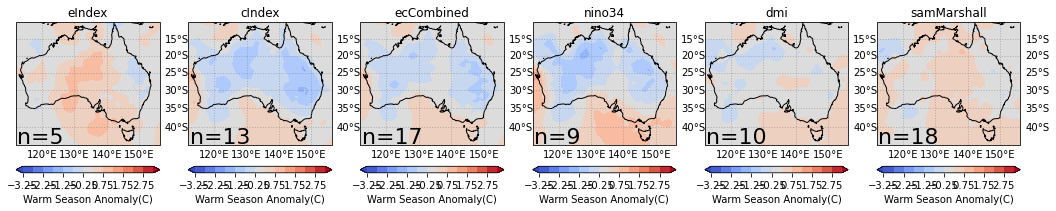

In [12]:
indexPlotter(prTWarmSeasonXr.precAnom, eventsXr.sel(fire='neg'), eventsLs)
plt.show()

indexPlotter(prTWarmSeasonXr.tsAnom, eventsXr.sel(fire='neg'), eventsLs)

# Compound them and see what happens

In [13]:
compoundEventsXr=compound.compound(eventsXr)

eIndexDmiSammarshall
eIndexEastioSammarshall
ecCombinedDmiSammarshall
ecCombinedEastioSammarshall
nino34DmiSammarshall
nino34EastioSammarshall
cIndexDmiSammarshall
cIndexEastioSammarshall


In [14]:
indexSet='ecCombinedDmiSammarshall'

In [15]:
compoundEventsXr[indexSet].to_dataset('compound')

<xarray.Dataset>
Dimensions:      (fire: 2, year: 64)
Coordinates:
  * year         (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
  * fire         (fire) object 'pos' 'neg'
Data variables:
    nEvents      (fire, year) float64 2.0 0.0 0.0 0.0 1.0 ... 2.0 1.0 0.0 2.0
    all3         (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    enso+iod     (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    enso+sam     (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 1.0
    iod+sam      (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    enso         (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iod          (fire, year) float64 0.0 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0
    sam          (fire, year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 1.0 0.0 0.0
    anyCompound  (fire, year) float64 1.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 1.0

In [16]:
compoundEventsLs=[*compoundEventsXr.pairs, 'all3']

In [17]:
compoundEventsXr[indexSet].sel(fire='pos', drop=True).to_dataset('compound')

<xarray.Dataset>
Dimensions:      (year: 64)
Coordinates:
  * year         (year) int64 1957 1958 1959 1960 1961 ... 2017 2018 2019 2020
Data variables:
    nEvents      (year) float64 2.0 0.0 0.0 0.0 1.0 0.0 ... 1.0 0.0 1.0 3.0 0.0
    all3         (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 0.0
    enso+iod     (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    enso+sam     (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    iod+sam      (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    enso         (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    iod          (year) float64 0.0 0.0 0.0 0.0 1.0 0.0 ... 0.0 0.0 1.0 0.0 0.0
    sam          (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 0.0 0.0 0.0 0.0
    anyCompound  (year) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 1.0 0.0

In [18]:
#enso+iod compound years, realWorld

for iCompound in compoundEventsLs:

    years=compoundEventsXr.where(
        compoundEventsXr[indexSet].sel(fire='pos', compound=iCompound)==True, 
        drop=True
    ).year.values
    
    print(str(iCompound) + ' : ' + str(years))

enso+iod : [1972 1994 1997 2015]
enso+sam : [1957 1968 1976 1982 1991 2002]
iod+sam : []
all3 : [2019]


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


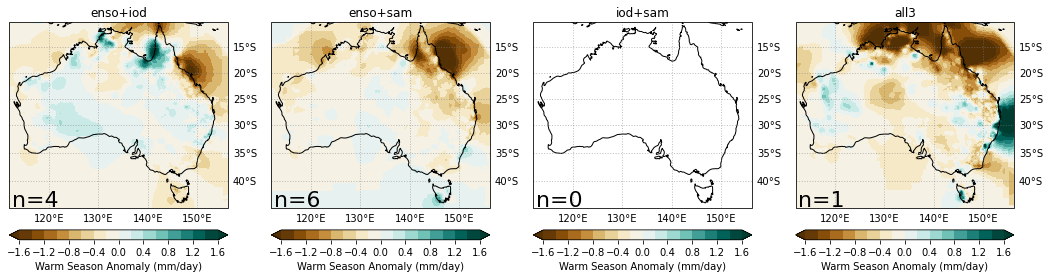

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


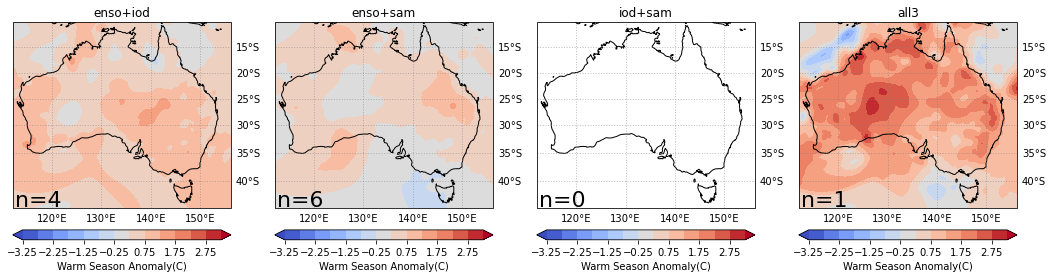

In [19]:
indexPlotter(
    prTWarmSeasonXr.precAnom, 
    compoundEventsXr[indexSet].sel(fire='pos', drop=True).to_dataset('compound'), 
    compoundEventsLs
)
plt.show()

indexPlotter(
    prTWarmSeasonXr.tsAnom, 
    compoundEventsXr[indexSet].sel(fire='pos', drop=True).to_dataset('compound'), 
    compoundEventsLs
)

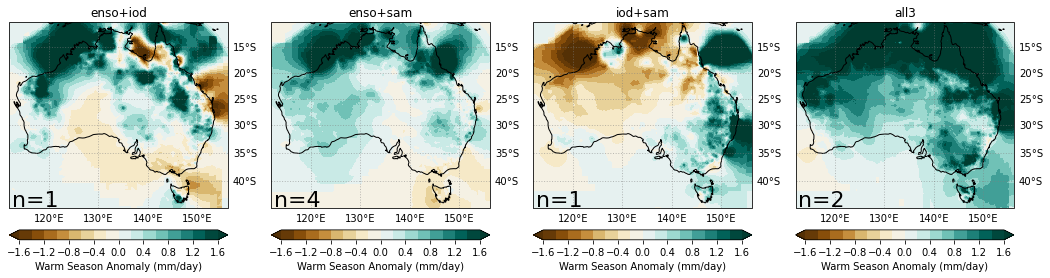

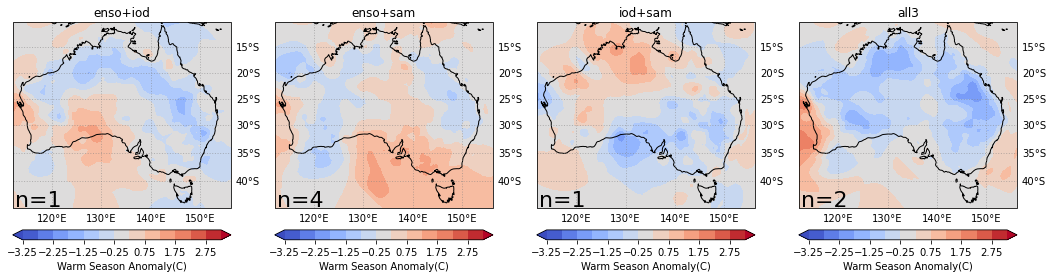

In [20]:
indexPlotter(
    prTWarmSeasonXr.precAnom, 
    compoundEventsXr[indexSet].sel(fire='neg', drop=True).to_dataset('compound'), 
    compoundEventsLs
)
plt.show()

indexPlotter(
    prTWarmSeasonXr.tsAnom, 
    compoundEventsXr[indexSet].sel(fire='neg', drop=True).to_dataset('compound'), 
    compoundEventsLs
)

# And comparison between the three enso indices

In [21]:
ensoIodEventsXr=compoundEventsXr.sel(compound='enso+iod', drop=True)

In [22]:
ensoIodEventsLs=list(ensoIodEventsXr.data_vars)

In [23]:
ensoIodEventsLs

['eIndexDmiSammarshall',
 'eIndexEastioSammarshall',
 'ecCombinedDmiSammarshall',
 'ecCombinedEastioSammarshall',
 'nino34DmiSammarshall',
 'nino34EastioSammarshall',
 'cIndexDmiSammarshall',
 'cIndexEastioSammarshall']

In [24]:
ensoIodEventsLs=[
    'ecCombinedDmiSammarshall',
    'cIndexDmiSammarshall',
    'eIndexDmiSammarshall'
]


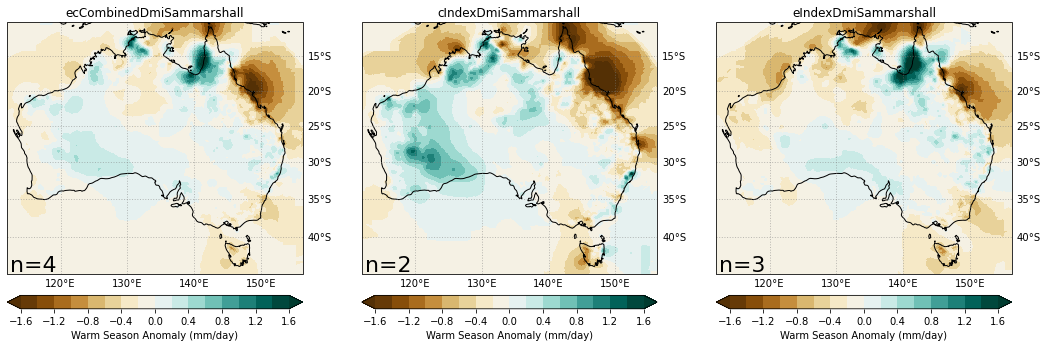

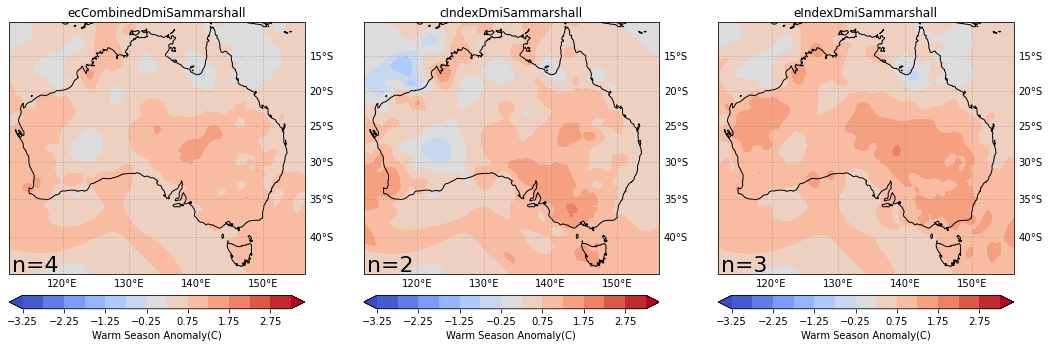

In [25]:
indexPlotter(
    prTWarmSeasonXr.precAnom, 
    ensoIodEventsXr.sel(fire='pos'), 
    ensoIodEventsLs
)
plt.show()

indexPlotter(
    prTWarmSeasonXr.tsAnom, 
    ensoIodEventsXr.sel(fire='pos'), 
    ensoIodEventsLs
)

n=0 for fire Neg Case